In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import plotly.io as pio


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
fig_dir = '/Users/fairliereese/mortazavi_lab/documents/rnawg/fig1/'

## Supplementary table - library level

In [4]:
swan_meta = 'cerberus/swan/swan_metadata.tsv'
read_annot = 'talon/human_talon_read_annot.tsv'
ali_table = 'ali_sample_table.csv'
file_hr = 'file_to_hr.tsv'

# for each library, get the following info

meta = pd.read_csv(file_hr, sep='\t', header=None, 
                   names=['ENCODE_file_id', 'dataset', 'sample_display'])

# add experiment id
df = pd.read_csv('metadata.tsv', sep='\t')
df = df[['File accession', 'Experiment accession']]
df.rename({'File accession': 'ENCODE_file_id',
           'Experiment accession': 'ENCODE_experiment_id'},
           axis=1, inplace=True)
meta = meta.merge(df, on='ENCODE_file_id')

# tissue / cell line, display name
swan_df = pd.read_csv(swan_meta, sep='\t')
swan_df.drop('sample_display', axis=1, inplace=True)
meta = meta.merge(swan_df, how='left', on='dataset')

# add hex code
c_dict, order = get_biosample_colors()
meta['sample_color_hex_code'] = meta['sample'].map(c_dict)

# ali's parent tissue / cell line classification
df = pd.read_csv(ali_table)
df.rename({'tissue / cell type':'general_tissue_cell_type'}, axis=1, inplace=True)
df = df.loc[df.species=='Human']
df = df[['sample', 'general_tissue_cell_type']].drop_duplicates()
meta = meta.merge(df, how='left', on='sample')

# number of reads post-talon
df = pd.read_csv(read_annot, usecols=[0,1], sep='\t')
df = df.groupby('dataset').count().reset_index()
meta = meta.merge(df, how='left', on='dataset')

# tissue / dish labelled in figure 1a
df = pd.read_csv('closest_tissue_of_origin.tsv', sep='\t')
df.rename({'Closest tissue of origin': 'fig1_tissue_label'}, axis=1, inplace=True)
df = df[['biosample', 'fig1_tissue_label']]
meta = meta.merge(df, how='left', left_on='sample', right_on='biosample')
meta.drop('biosample', axis=1, inplace=True)

## add mouse matching samples
samples = get_mouse_match_samples()

# sample to tissue dict for mouse
st_dict = {'adrenal gland': ['adrenal'],
           'heart': ['heart'],
           'muscle': ['gastroc', 'c2c12_myoblast', 'c2c12_myotube', 'forelimb'],
           'brain': ['cortex', 'hippocampus'],
           'pgp1_excite_neuron': ['cortex', 'hippocampus'],
           'pgp1_astro': ['cortex', 'hippocampus'],
           'h9_osteocyte': ['forelimb'],
           'h1': ['f1219'],
           'wtc11': ['f1219']}

df = pd.read_csv('../mouse/lr_bulk/swan/mouse_metadata.tsv', sep='\t')
df = df[['tissue', 'sample']].drop_duplicates()
df = df.groupby('tissue').agg({'sample': ','.join}).reset_index()

meta['mouse_tissue'] = meta['sample'].map(st_dict)
def get_human_mouse_samples(x, df):
    if not type(x.mouse_tissue) == list:
        return None
    samples = df.loc[df['tissue'].isin(x.mouse_tissue)].copy(deep=True)
    samples['temp'] = 1
    samples = samples[['sample', 'temp']]
    samples = samples.groupby('temp').agg({'sample': ','.join}).reset_index()['sample'].values[0]
    return samples
meta['matching_mouse_samples'] = meta.apply(lambda x: get_human_mouse_samples(x, df), axis=1)

meta.drop('mouse_tissue', axis=1, inplace=True)
meta.rename({'classification': 'tissue_or_cell_line',
             'read_name': 'reads_post_talon'}, axis=1, inplace=True)


order = ['ENCODE_file_id', 
         'ENCODE_experiment_id', 
         'dataset',
         'sample', 'sample_display', 
         'general_tissue_cell_type', 'fig1_tissue_label',
         'health_status', 'tissue_or_cell_line', 'sample_color_hex_code',
         'matching_mouse_samples',
         'reads_post_talon']
meta = meta[order]

meta.to_csv('lr_human_library_data_summary.tsv', sep='\t', index=False)

## Supplementary table - sample level

In [32]:
swan_meta = 'cerberus/swan/swan_metadata.tsv'
read_annot = 'talon/human_talon_read_annot.tsv'
ali_table = 'ali_sample_table.csv'

# for each sample, get the following info

# tissue / cell line, display name
meta = pd.read_csv(swan_meta, sep='\t')

# number of libraries
meta = meta[['dataset', 'sample', 'classification', 'sample_display']]
meta = meta.groupby(['sample', 'classification', 'sample_display']).count().reset_index()
meta.rename({'dataset': 'n_libraries'}, axis=1, inplace=True)

# add hex code
c_dict, order = get_biosample_colors()
meta['hex_code'] = meta['sample'].map(c_dict)

# ali's parent tissue / cell line classification
df = pd.read_csv(ali_table)
df = df.loc[df.species=='Human']
df = df[['sample', 'tissue / cell type']].drop_duplicates()
meta = meta.merge(df, how='left', on='sample')

# # number of reads post-talon
# df = pd.read_csv(read_annot, usecols=[0,1], sep='\t')
# meta2 = pd.read_csv(swan_meta, sep='\t')
# meta2 = meta2[['sample', 'dataset']]
# df = df.merge(meta2, how='left', on='dataset')
# df = df.groupby('sample').count().reset_index()
# df.rename({'read_name': 'n_reads'}, axis=1, inplace=True)
# meta = meta.merge(df, how='left', on='sample')
# meta.drop('dataset', axis=1, inplace=True)

# tissue / dish labelled in figure 1a
df = pd.read_csv('closest_tissue_of_origin.tsv', sep='\t')
df = df[['biosample', 'Closest tissue of origin']]
meta = meta.merge(df, how='left', left_on='sample', right_on='biosample')
meta.drop('biosample', axis=1, inplace=True)

# file IDs / human-readable dataset names assc. w/ each sample
df = pd.read_csv('file_to_hr.tsv', sep='\t', header=None, names=['file_id', 'hr', 'sample_display'])
df = df.groupby('sample_display').agg({'file_id': ','.join, 'hr': ','.join}).reset_index()
meta = meta.merge(df, how='left', on='sample_display')

## add mouse matching samples
samples = get_mouse_match_samples()

# sample to tissue dict for mouse
st_dict = {'adrenal gland': ['adrenal'],
           'heart': ['heart'],
           'muscle': ['gastroc', 'c2c12_myoblast', 'c2c12_myotube', 'forelimb'],
           'brain': ['cortex', 'hippocampus'],
           'pgp1_excite_neuron': ['cortex', 'hippocampus'],
           'pgp1_astro': ['cortex', 'hippocampus'],
           'h9_osteocyte': ['forelimb'],
           'h1': ['f1219'],
           'wtc11': ['f1219']}

df = pd.read_csv('../mouse/lr_bulk/swan/mouse_metadata.tsv', sep='\t')
df = df[['tissue', 'sample']].drop_duplicates()
df = df.groupby('tissue').agg({'sample': ','.join}).reset_index()

meta['mouse_tissue'] = meta['sample'].map(st_dict)
def get_human_mouse_samples(x, df):
    if not type(x.mouse_tissue) == list:
        return None
    samples = df.loc[df['tissue'].isin(x.mouse_tissue)].copy(deep=True)
    samples['temp'] = 1
    samples = samples[['sample', 'temp']]
    samples = samples.groupby('temp').agg({'sample': ','.join}).reset_index()['sample'].values[0]
    return samples
meta['matching_mouse_samples'] = meta.apply(lambda x: get_human_mouse_samples(x, df), axis=1)

meta.rename({'classification': 'tissue_or_cell_line',
             'tissue / cell type': 'general_tissue_cell_type',
             'Closest tissue of origin': 'fig1_tissue_label',
             'file_id': 'ENCODE_file_ids',
             'dataset': 'dataset_ids'}, axis=1, inplace=True)



In [33]:
meta.head()

,sample,classification,sample_display,n_libraries,hex_code,tissue / cell type,n_reads,Closest tissue of origin,file_id,hr
0,a673,cell_line,A673,2,#de3700,a673,3037401,bone,"ENCFF045ZQI,ENCFF320GCF","a673_1_1,a673_1_2"
1,adipose,tissue,Adipose,1,#f5bb50,adipose,1794731,adipose,ENCFF971JDY,mesenteric_fat_pad_1_1
2,adrenal gland,tissue,Adrenal gland,3,#e69b00,adrenal gland,2922026,adrenal gland,"ENCFF147OYL,ENCFF791WUV,ENCFF243PFI","adrenal_gland_1_1,adrenal_gland_2_1,adrenal_gl..."
3,brain,tissue,Brain,9,#b0799a,cortex,18460809,brain,"ENCFF773RAW,ENCFF114VSO,ENCFF279ABL,ENCFF877QJ...","brodmann_area_46_1_1,brodmann_area_46_2_1,brod..."
4,caco2,cell_line,Caco2,2,#ff9000,caco2,3065329,colon,"ENCFF835KGV,ENCFF899RYN","caco2_1_1,caco2_1_2"


In [48]:
meta.to_csv('lr_human_data_summary.tsv', sep='\t', index=False)

In [ ]:
## Add tissue labelled in 1a

In [21]:
meta = pd.read_csv('lr_human_data_summary.tsv', sep='\t')

In [22]:
df = pd.read_csv('closest_tissue_of_origin.tsv', sep='\t')
df = df[['biosample', 'Closest tissue of origin']]
meta = meta.merge(df, how='left', left_on='sample', right_on='biosample')
meta.drop('biosample', axis=1, inplace=True)
meta.head()

,sample,classification,sample_display,n_libraries,hex_code,tissue / cell type,n_reads,dataset,Closest tissue of origin
0,a673,cell_line,A673,2,#de3700,a673,3037401,3037401,bone
1,adipose,tissue,Adipose,1,#f5bb50,adipose,1794731,1794731,adipose
2,adrenal gland,tissue,Adrenal gland,3,#e69b00,adrenal gland,2922026,2922026,adrenal gland
3,brain,tissue,Brain,9,#b0799a,cortex,18460809,18460809,brain
4,caco2,cell_line,Caco2,2,#ff9000,caco2,3065329,3065329,colon


In [23]:
## add the file IDs and hr file IDs to table

In [26]:
df = pd.read_csv('file_to_hr.tsv', sep='\t', header=None, names=['file_id', 'hr', 'sample_display'])
df = df.groupby('sample_display').agg({'file_id': ','.join, 'hr': ','.join}).reset_index()
meta = meta.merge(df, how='left', on='sample_display')

In [49]:
## add mouse matching samples
samples = get_mouse_match_samples()

# sample to tissue dict for mouse
st_dict = {'adrenal gland': ['adrenal'],
           'heart': ['heart'],
           'muscle': ['gastroc', 'c2c12_myoblast', 'c2c12_myotube', 'forelimb'],
           'brain': ['cortex', 'hippocampus'],
           'pgp1_excite_neuron': ['cortex', 'hippocampus'],
           'pgp1_astro': ['cortex', 'hippocampus'],
           'h9_osteocyte': ['forelimb'],
           'h1': ['f1219'],
           'wtc11': ['f1219']}

df = pd.read_csv('../mouse/lr_bulk/swan/mouse_metadata.tsv', sep='\t')
df = df[['tissue', 'sample']].drop_duplicates()
df = df.groupby('tissue').agg({'sample': ','.join}).reset_index()

meta['mouse_tissue'] = meta['sample'].map(st_dict)
def get_human_mouse_samples(x, df):
    if not type(x.mouse_tissue) == list:
        return None
    samples = df.loc[df['tissue'].isin(x.mouse_tissue)].copy(deep=True)
    samples['temp'] = 1
    samples = samples[['sample', 'temp']]
    samples = samples.groupby('temp').agg({'sample': ','.join}).reset_index()['sample'].values[0]
    return samples
meta['matching_mouse_samples'] = meta.apply(lambda x: get_human_mouse_samples(x, df), axis=1)
meta.drop('mouse_tissue', axis=1, inplace=True)


,sample,classification,sample_display,n_libraries,hex_code,tissue / cell type,n_reads,Closest tissue of origin,file_id,hr,mouse_tissue,matching_mouse_samples
0,a673,cell_line,A673,2,#de3700,a673,3037401,bone,"ENCFF045ZQI,ENCFF320GCF","a673_1_1,a673_1_2",NaN,None
1,adipose,tissue,Adipose,1,#f5bb50,adipose,1794731,adipose,ENCFF971JDY,mesenteric_fat_pad_1_1,NaN,None
2,adrenal gland,tissue,Adrenal gland,3,#e69b00,adrenal gland,2922026,adrenal gland,"ENCFF147OYL,ENCFF791WUV,ENCFF243PFI","adrenal_gland_1_1,adrenal_gland_2_1,adrenal_gl...",[adrenal],"adrenal,adrenal_10d,adrenal_14d,adrenal_18-20m..."
3,brain,tissue,Brain,9,#b0799a,cortex,18460809,brain,"ENCFF773RAW,ENCFF114VSO,ENCFF279ABL,ENCFF877QJ...","brodmann_area_46_1_1,brodmann_area_46_2_1,brod...","[cortex, hippocampus]","cortex,cortex_14d,cortex_18-20mo,cortex_2mo,hi..."
4,caco2,cell_line,Caco2,2,#ff9000,caco2,3065329,colon,"ENCFF835KGV,ENCFF899RYN","caco2_1_1,caco2_1_2",NaN,None


In [50]:
meta.to_csv('lr_human_data_summary.tsv', sep='\t', index=False)

In [51]:
meta.rename({'classification': 'tissue_or_cell_line',
             'tissue / cell type': 'general_tissue_cell_type',
             'Closest tissue of origin': 'fig1_tissue_label',
             'file_id': 'ENCODE_file_ids',
             'dataset': 'dataset_ids'}, axis=1, inplace=True)

In [52]:
meta.head()

,sample,tissue_or_cell_line,sample_display,n_libraries,hex_code,general_tissue_cell_type,n_reads,fig1_tissue_label,ENCODE_file_ids,hr,mouse_tissue,matching_mouse_samples
0,a673,cell_line,A673,2,#de3700,a673,3037401,bone,"ENCFF045ZQI,ENCFF320GCF","a673_1_1,a673_1_2",NaN,None
1,adipose,tissue,Adipose,1,#f5bb50,adipose,1794731,adipose,ENCFF971JDY,mesenteric_fat_pad_1_1,NaN,None
2,adrenal gland,tissue,Adrenal gland,3,#e69b00,adrenal gland,2922026,adrenal gland,"ENCFF147OYL,ENCFF791WUV,ENCFF243PFI","adrenal_gland_1_1,adrenal_gland_2_1,adrenal_gl...",[adrenal],"adrenal,adrenal_10d,adrenal_14d,adrenal_18-20m..."
3,brain,tissue,Brain,9,#b0799a,cortex,18460809,brain,"ENCFF773RAW,ENCFF114VSO,ENCFF279ABL,ENCFF877QJ...","brodmann_area_46_1_1,brodmann_area_46_2_1,brod...","[cortex, hippocampus]","cortex,cortex_14d,cortex_18-20mo,cortex_2mo,hi..."
4,caco2,cell_line,Caco2,2,#ff9000,caco2,3065329,colon,"ENCFF835KGV,ENCFF899RYN","caco2_1_1,caco2_1_2",NaN,None


## How many libraries / closest tissue of origin do we have?

In [8]:
df = pd.read_csv('closest_tissue_of_origin.tsv', sep='\t')
df = df[['# libraries', 'Closest tissue of origin']]
df = df.groupby('Closest tissue of origin').sum().reset_index()
print(df)

   Closest tissue of origin  # libraries
0                   adipose            1
1             adrenal gland            3
2                     blood           30
3                      bone            4
4                     brain           13
5                    breast            5
6                 cartilage            6
7                     colon            6
8                      dish           19
9                     heart           17
10                   kidney            1
11                    liver            5
12                     lung           11
13                   muscle            2
14                    ovary            3
15                 pancreas            5
16                 prostate            1
17                  vessels            6


## How many reads / sample do we have?

In [6]:
read_annot = 'talon/human_talon_read_annot.tsv'
df = pd.read_csv(read_annot, usecols=[0, 1], sep='\t')

In [7]:
df['biosample'] = df.dataset.str.rsplit('_', n=2, expand=True)[0]
df.drop(['dataset'], axis=1, inplace=True)

# record the highest TPM value per biosample
tissue_df = get_tissue_metadata()
tissue_df = tissue_df[['tissue', 'biosample']]

df = df.merge(tissue_df, how='left', on='biosample')
df.loc[df.tissue.isnull(), 'tissue'] = df.loc[df.tissue.isnull(), 'biosample']
df.drop('biosample', axis=1, inplace=True)
df.rename({'tissue': 'biosample'}, axis=1, inplace=True)

In [9]:
df = df.groupby('biosample').count().reset_index()

In [10]:
df.head()

,biosample,read_name
0,a673,3037401
1,adipose,1794731
2,adrenal gland,2922026
3,brain,18460809
4,caco2,3065329


In [19]:
sort_df = pd.read_csv('cerberus/swan/swan_metadata.tsv', sep='\t')
sort_df = sort_df[['sample', 'classification']]
sort_df = sort_df.drop_duplicates()
df = df.merge(sort_df, how='left', left_on='biosample', right_on='sample')
df = df.sort_values(by=['classification', 'sample'], ascending=True)

In [16]:
df.to_csv('reads_per_sample.tsv', sep='\t')

## Summary table

In [14]:
df = pd.read_csv('cerberus/swan/swan_metadata.tsv', sep='\t')
df.head()
df = df[['dataset', 'sample', 'classification', 'sample_display']]
df = df.groupby(['classification', 'sample', 'sample_display']).count().reset_index()
df.rename({'dataset': 'n_libraries'}, axis=1, inplace=True)
df2 = pd.read_csv('ali_sample_table.csv')

In [15]:
df2 = df2[['sample', 'tissue / cell type']].drop_duplicates()
df = df.merge(df2, on='sample', how='left')
df = df.sort_values(by=['classification', 'sample_display'], ascending=True)
df.head()

,classification,sample,sample_display,n_libraries,tissue / cell type
0,cell_line,a673,A673,2,a673
1,cell_line,caco2,Caco2,2,caco2
2,cell_line,calu3,Calu-3,2,calu3
3,cell_line,gm12878,GM12878,7,gm12878
4,cell_line,h1,H1,3,ES


In [16]:
df.to_csv(f'{fig_dir}/human_samples_supp_table.tsv', sep='\t', index=False)

## legend

       dataset   sample classification health_status sample_display
0  gm12878_1_1  gm12878      cell_line           NaN        GM12878
1  gm12878_1_2  gm12878      cell_line           NaN        GM12878
2  gm12878_1_3  gm12878      cell_line           NaN        GM12878
3  gm12878_1_4  gm12878      cell_line           NaN        GM12878
4  gm12878_3_1  gm12878      cell_line           NaN        GM12878


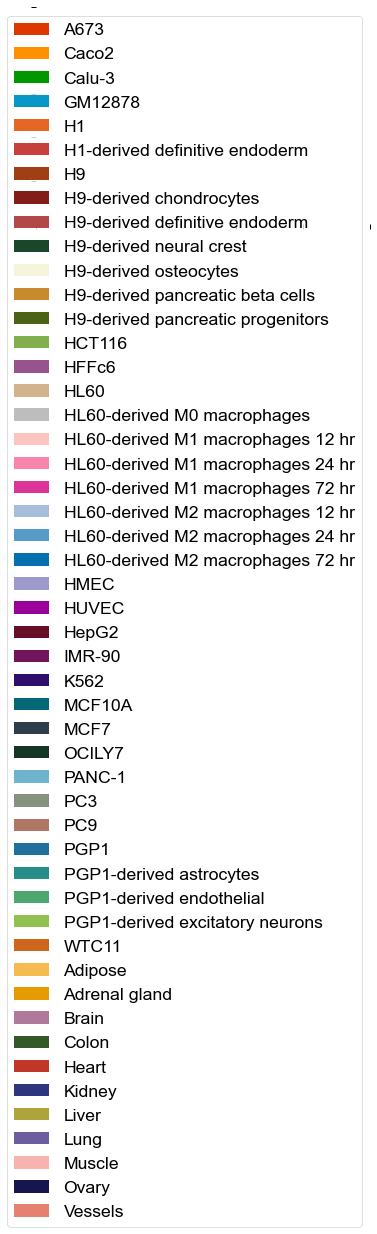

In [79]:

df = pd.read_csv('swan/swan_metadata.tsv', sep='\t')
print(df.head())
df = df[['sample', 'sample_display', 'classification']]
df = df.drop_duplicates()
df = df.sort_values(by=['classification', 'sample_display'], ascending=True)
order = df.sample_display.tolist()
df['number'] = [i for i in range(len(df.index))]
c_dict, _ = get_biosample_colors()
c_dict_2 = {}
for key, item in c_dict.items():
    key2 = df.loc[df['sample'] == key, 'sample_display'].values[0]
    c_dict_2[key2] = item
df['sample_display'] = df['sample_display'].astype('category')
df['sample_display'].cat.categories = order
import matplotlib.patches as patches
samples = []
for s in df.sample_display.cat.categories:
    c = c_dict_2[s]
    samples.append(patches.Rectangle((0,0),1,1,facecolor=c))
ax = sns.scatterplot()
plt.legend(samples, df.sample_display.cat.categories)

ax.set_xticklabels('')
ax.set_yticklabels('')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fname = f'{fig_dir}/human_lr_bulk_samples.pdf'
plt.savefig(fname, dpi=700, bbox_inches='tight')

    
# ax = sns.catplot(data=df, x='number', y='number',
#             hue='sample_display', palette=c_dict_2, order=order)


## Plots from Diane's analyses

In [2]:
# !wget https://woldlab.caltech.edu/~diane/encode4-rna-wg-paper/all_summary_counts.tsv
# !wget https://woldlab.caltech.edu/~diane/encode4-rna-wg-paper/bam_read_summary.csv
# !wget https://woldlab.caltech.edu/~diane/encode4-rna-wg-paper/fastq_lengths.csv

In [25]:
bam_reads = pd.read_csv("bam_read_summary.csv", index_col=0, header=[0,1])
fastq_reads = pd.read_csv("fastq_lengths.csv", index_col=0, header=[0])

read_counts = pd.merge(bam_reads[[("primary", "count")]], fastq_reads[["count"]], left_index=True, right_index=True)
read_counts.columns = ["aligned_read_count", "fastq_read_count"]
read_counts["aligned_gt"] = (read_counts["aligned_read_count"] > read_counts["fastq_read_count"])
read_counts.reset_index(inplace=True)
df = read_counts.copy(deep=True)

# add sample information
# df.rename({'Unnamed: 0':'dataset'}, axis=1, inplace=True)
df.rename({'index':'dataset'}, axis=1, inplace=True)
df['exp_id'] = df.dataset.str.split('_', expand=True)[0]
meta = pd.read_csv('metadata.tsv', sep='\t')
meta = meta[['File accession', 'Experiment accession']]
df = df.merge(meta, how='left', left_on='exp_id', right_on='Experiment accession')
fhr = pd.read_csv('file_to_hr.tsv', sep='\t', header=None, names=['file_id', 'dataset_hr'])
df = df.merge(fhr, how='left', left_on='File accession', right_on='file_id')
temp = df[['dataset_hr']]
temp.rename({'dataset_hr':'dataset'}, axis=1, inplace=True)
temp = add_sample(temp)
df = df.merge(temp, how='left', left_on='dataset_hr', right_on='dataset')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  after removing the cwd from sys.path.


In [26]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_biosample_colors()

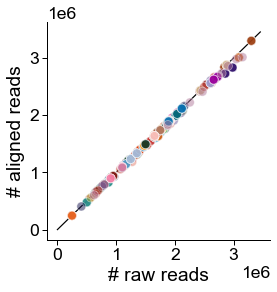

In [27]:
plt.figure(figsize=(4,4))
ax = sns.scatterplot(df, x='fastq_read_count', y='aligned_read_count',
                     hue='sample', palette=c_dict, alpha=0.5,
                     s=80)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
_ = ax.plot([0,xmax], [0,xmax], color='k', zorder=0)
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
xlabel = '# raw reads'
ylabel = '# aligned reads'
_ = ax.set(xlabel=xlabel, ylabel=ylabel)

fname = f'{fig_dir}raw_vs_aligned_reads.pdf'
plt.savefig(fname, dpi=700, bbox_inches='tight')

In [28]:
primary_median = pd.merge(bam_reads[[("primary", "median")]], fastq_reads[["median"]], left_index=True, right_index=True)
primary_median.columns = ["primary_read_median", "fastq_read_median"]
primary_median.reset_index(inplace=True)
df = primary_median.copy(deep=True)

# add sample information
# df.rename({'Unnamed: 0':'dataset'}, axis=1, inplace=True)
df.rename({'index':'dataset'}, axis=1, inplace=True)
df['exp_id'] = df.dataset.str.split('_', expand=True)[0]
meta = pd.read_csv('metadata.tsv', sep='\t')
meta = meta[['File accession', 'Experiment accession']]
df = df.merge(meta, how='left', left_on='exp_id', right_on='Experiment accession')
fhr = pd.read_csv('file_to_hr.tsv', sep='\t', header=None, names=['file_id', 'dataset_hr'])
df = df.merge(fhr, how='left', left_on='File accession', right_on='file_id')
temp = df[['dataset_hr']]
temp.rename({'dataset_hr':'dataset'}, axis=1, inplace=True)
temp = add_sample(temp)
df = df.merge(temp, how='left', left_on='dataset_hr', right_on='dataset')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  """Entry point for launching an IPython kernel.


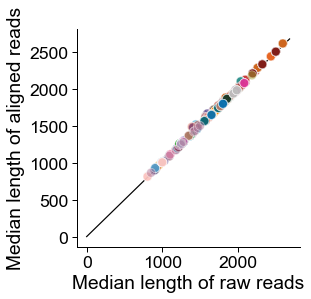

In [29]:
plt.figure(figsize=(4,4))
ax = sns.scatterplot(df, x='fastq_read_median', y='primary_read_median',
                     hue='sample', palette=c_dict, alpha=0.5, s=80)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
_ = ax.plot([0,xmax], [0,xmax], color='k', zorder=0)
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
xlabel = 'Median length of raw reads'
ylabel = 'Median length of aligned reads'
_ = ax.set(xlabel=xlabel, ylabel=ylabel)

fname = f'{fig_dir}raw_vs_aligned_read_median_lengths.pdf'
plt.savefig(fname, dpi=700, bbox_inches='tight')

## Scatterplot for # libraries vs. # tissues

In [16]:
fig_dir = '/Users/fairliereese/mortazavi_lab/documents/rnawg/fig1/'
df = pd.read_csv('ali_sample_table.csv')
c_dict, order = get_tissue_cell_line_colors()
style_dict = {'Human': 'o', 'Mouse': 'D'}

In [17]:
# gb species and classification and count tissue / cell type
temp2 = df.groupby(['classification', 'species']).nunique().reset_index()
temp2 = temp2[['classification', 'species', 'tissue / cell type']]
temp2.rename({'tissue / cell type': 'n_tissue_cell_type'}, axis=1, inplace=True)

In [18]:
# gb species and classification and count libraries
temp = df.groupby(['classification', 'species']).count().reset_index()
temp = temp[['classification', 'species', 'dataset']]
temp.rename({'dataset': 'n_libraries'}, axis=1, inplace=True)

In [19]:
temp = temp.merge(temp2, on=['classification', 'species'])

In [20]:
temp

,classification,species,n_libraries,n_tissue_cell_type
0,cell_line,Human,87,30
1,cell_line,Mouse,9,2
2,tissue,Human,51,11
3,tissue,Mouse,117,6


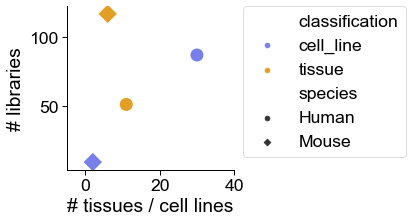

In [22]:
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(3,3))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

ax = sns.scatterplot(data=temp, x='n_tissue_cell_type', y='n_libraries',
            hue='classification', style='species', markers=style_dict,
            palette=c_dict, alpha=1, s=200)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

xlabel = '# tissues / cell lines'
ylabel = '# libraries'
xlim = (-5, 40)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
_ = ax.set(xlabel=xlabel, ylabel=ylabel, xlim=xlim)

fname = 'figures/data_summary_libraries_v_tissue_cell_line.pdf'
plt.savefig(fname, dpi=500, layout='tight', bbox_inches="tight")

fname = '{}/data_summary_libraries_v_tissue_cell_line.pdf'.format(fig_dir)
plt.savefig(fname, dpi=500, layout='tight', bbox_inches="tight")

## PCA plot / UMAP for protein-coding genes expressed in each dataset

In [80]:
import umap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.imputils', please update to use 'numba.core.imputils' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'impl_ret_borrowed' requested from: 'numba.targets.imputils', pleas

In [81]:
filt_ab = 'cerberus/cerberus_filtered_abundance.tsv'
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df,
               how='iso',
               min_tpm=1,
               gene_subset='polya')

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1854: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1853: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476


In [82]:
ab = 'talon/human_talon_abundance.tsv'
df = pd.read_csv(ab, sep='\t')
df, gids = get_tpm_table(df,
                   how='gene',
                   min_tpm=1,
                   gene_subset='polya')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 599976
# genes >= 1 tpm: 292060
Applying gene type and novelty subset
Number of genes reported: 33772


In [83]:
# using scanpy

In [84]:
swan_file = 'cerberus/swan/swan.p'
sg = swan.read(swan_file)
sg.gene_adata.var['gid_stable'] = cerberus.get_stable_gid(sg.gene_adata.var, col='gid')
sg.gene_adata.var.reset_index(drop=True)
sg.gene_adata.var.set_index('gid_stable', inplace=True)

Read in graph from cerberus/swan/swan.p


In [85]:
sg.gene_adata.var.tail()

,gid
gid_stable,
ENSG00000285987,ENSG00000285987.1
ENSG00000285988,ENSG00000285988.1
ENSG00000285990,ENSG00000285990.1
ENSG00000285991,ENSG00000285991.1
ENSG00000285992,ENSG00000285992.1


Trying to set attribute `.obs` of view, copying.


['a673', 'adipose', 'adrenal gland', 'brain', 'caco2', 'calu3', 'colon', 'gm12878', 'h1', 'h1_de', 'h9', 'h9_chondro', 'h9_de', 'h9_neural_crest', 'h9_osteocyte', 'h9_panc_beta', 'h9_panc_progen', 'hct116', 'heart', 'hepg2', 'hffc6', 'hl60', 'hl60_m0', 'hl60_m1_12hr', 'hl60_m1_24hr', 'hl60_m1_72hr', 'hl60_m2_12hr', 'hl60_m2_24hr', 'hl60_m2_72hr', 'hmec', 'huvec', 'imr90', 'k562', 'kidney', 'liver', 'lung', 'mcf10a', 'mcf7', 'muscle', 'ocily7', 'ovary', 'panc1', 'pc3', 'pc9', 'pgp1', 'pgp1_astro', 'pgp1_endo', 'pgp1_excite_neuron', 'vessels', 'wtc11']
['gm12878', 'pgp1', 'h9', 'hct116', 'hepg2', ..., 'hl60_m2_24hr', 'a673', 'h1_de', 'calu3', 'brain']
Length: 50
Categories (50, object): ['a673', 'adipose', 'adrenal gland', 'brain', ..., 'pgp1_endo', 'pgp1_excite_neuron', 'vessels', 'wtc11']


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'classification' as categorical
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reo

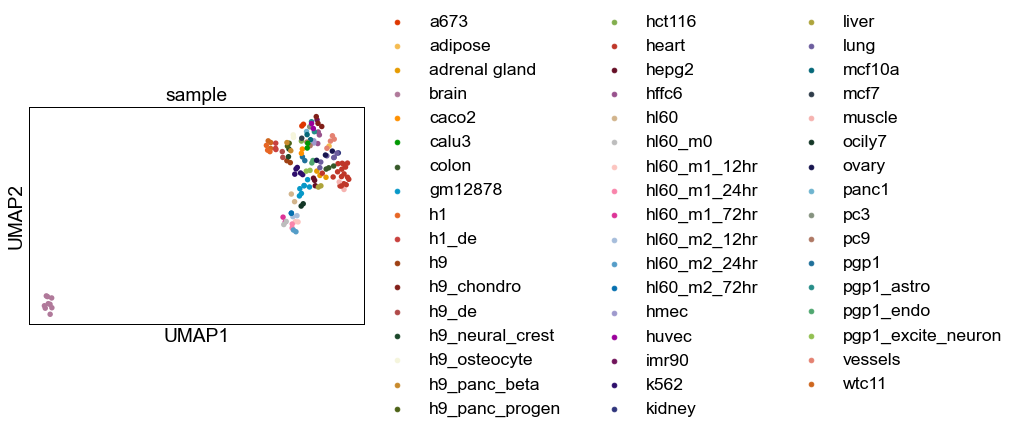

In [86]:
# gene adata
adata = sg.gene_adata[:, gids]
len(adata.var.index)

obs_col = 'sample'

# add colors
# map values in order specific to
cmap, order = get_biosample_colors()
adata.obs[obs_col] = adata.obs[obs_col].astype('category')
obs_order = list(adata.obs_names)
sample_order = adata.obs[obs_col].cat.categories.tolist()
print(sample_order)
print(adata.obs[obs_col].unique())
sample_colors = [cmap[s] for s in sample_order]
adata.uns['{}_colors'.format(obs_col)] = sample_colors

# also store rgb values in dict for use with gen_report
for key, item in cmap.items():
    item = item[1:]
    r,g,b = tuple(int(item[i:i+2], 16) for i in (0, 2, 4))
    cmap[key] = (r,g,b)
adata.uns['{}_dict'.format(obs_col)] = cmap

# normalize data matrix to 10,000 count
sc.pp.normalize_total(adata, target_sum=1e4)

# log 
sc.pp.log1p(adata)
adata.raw = adata

# find highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes = 12000, flavor = 'seurat',
    min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

# sc.tl.pca(adata, use_highly_variable=False)
sc.tl.pca(adata, use_highly_variable=True)

sc.pp.neighbors(adata, metric='cosine')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(adata, color='sample', frameon=True, size=120, show=False)

f = plt.gcf()
f.savefig('figures/lr_gene_umap.pdf', dpi=500, bbox_inches='tight')
f.savefig('/Users/fairliereese/mortazavi_lab/documents/rnawg/fig1/lr_gene_umap.pdf', dpi=500, bbox_inches='tight')



Trying to set attribute `.obs` of view, copying.


['cell_line', 'tissue', 'brain']
{'cell_line': '#7680e8', 'tissue': '#e39f24', 'brain': '#b0799a'}
['brain', 'cell_line', 'tissue']
['cell_line', 'tissue', 'brain']
Categories (3, object): ['brain', 'cell_line', 'tissue']


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample' as categorical
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'classification' as categorical
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a fut

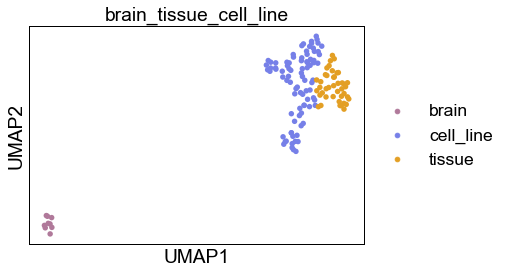

In [195]:
# gene adata
adata = sg.gene_adata[:, gids]
len(adata.var.index)

obs_col = 'brain_tissue_cell_line'
adata.obs[obs_col] = adata.obs.classification
adata.obs.loc[adata.obs['sample']=='brain', obs_col] = 'brain'

# add colors
# map values in order specific to
cmap, order = get_tissue_cell_line_colors()
cmap2, _ = get_biosample_colors()
brain_color = cmap2['brain'] 
order += ['brain']
print(order)
cmap['brain'] = brain_color
print(cmap)
adata.obs[obs_col] = adata.obs[obs_col].astype('category')
obs_order = list(adata.obs_names)
sample_order = adata.obs[obs_col].cat.categories.tolist()
print(sample_order)
print(adata.obs[obs_col].unique())
sample_colors = [cmap[s] for s in sample_order]
adata.uns['{}_colors'.format(obs_col)] = sample_colors

# also store rgb values in dict for use with gen_report
for key, item in cmap.items():
    item = item[1:]
    r,g,b = tuple(int(item[i:i+2], 16) for i in (0, 2, 4))
    cmap[key] = (r,g,b)
adata.uns['{}_dict'.format(obs_col)] = cmap

# normalize data matrix to 10,000 count
sc.pp.normalize_total(adata, target_sum=1e4)

# log 
sc.pp.log1p(adata)
adata.raw = adata

# find highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes = 12000, flavor = 'seurat',
    min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

# sc.tl.pca(adata, use_highly_variable=False)
sc.tl.pca(adata, use_highly_variable=True)

sc.pp.neighbors(adata, metric='cosine')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(adata, color=obs_col, frameon=True, size=120, show=False)

f = plt.gcf()
f.savefig('figures/lr_gene_umap_brain_tissue_cell_line.pdf', dpi=500, bbox_inches='tight')
f.savefig('/Users/fairliereese/mortazavi_lab/documents/rnawg/fig1/lr_gene_umap_brain_tissue_cell_line.pdf', dpi=500, bbox_inches='tight')



Trying to set attribute `.obs` of view, copying.


['a673', 'adipose', 'adrenal gland', 'caco2', 'calu3', 'colon', 'gm12878', 'h1', 'h1_de', 'h9', 'h9_chondro', 'h9_de', 'h9_neural_crest', 'h9_osteocyte', 'h9_panc_beta', 'h9_panc_progen', 'hct116', 'heart', 'hepg2', 'hffc6', 'hl60', 'hl60_m0', 'hl60_m1_12hr', 'hl60_m1_24hr', 'hl60_m1_72hr', 'hl60_m2_12hr', 'hl60_m2_24hr', 'hl60_m2_72hr', 'hmec', 'huvec', 'imr90', 'k562', 'kidney', 'liver', 'lung', 'mcf10a', 'mcf7', 'muscle', 'ocily7', 'ovary', 'panc1', 'pc3', 'pc9', 'pgp1', 'pgp1_astro', 'pgp1_endo', 'pgp1_excite_neuron', 'vessels', 'wtc11']
['gm12878', 'pgp1', 'h9', 'hct116', 'hepg2', ..., 'hl60_m1_24hr', 'hl60_m2_24hr', 'a673', 'h1_de', 'calu3']
Length: 49
Categories (49, object): ['a673', 'adipose', 'adrenal gland', 'caco2', ..., 'pgp1_endo', 'pgp1_excite_neuron', 'vessels', 'wtc11']


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'classification' as categorical


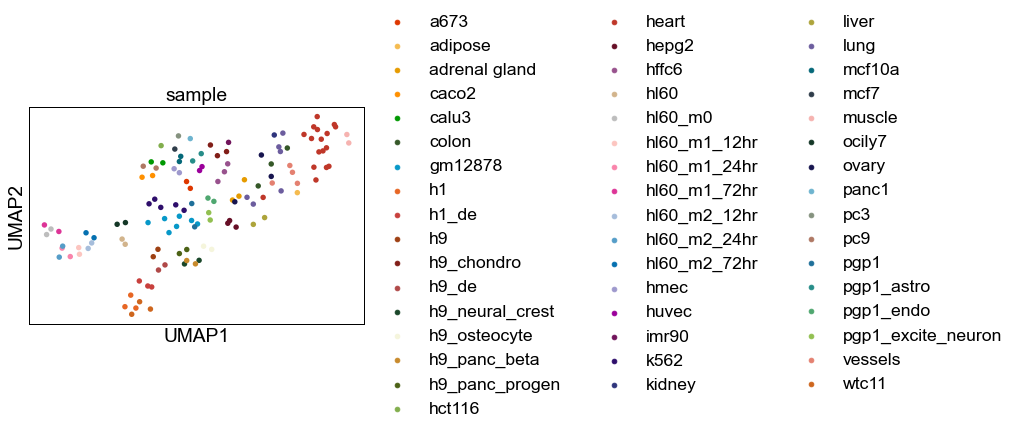

In [87]:
# gene adata - no brain
adata = sg.gene_adata[:, gids]
adata = adata[adata.obs['sample'] != 'brain']
len(adata.var.index)

obs_col = 'sample'

# add colors
# map values in order specific to
cmap, order = get_biosample_colors()
adata.obs[obs_col] = adata.obs[obs_col].astype('category')
obs_order = list(adata.obs_names)
sample_order = adata.obs[obs_col].cat.categories.tolist()
print(sample_order)
print(adata.obs[obs_col].unique())
sample_colors = [cmap[s] for s in sample_order]
adata.uns['{}_colors'.format(obs_col)] = sample_colors

# also store rgb values in dict for use with gen_report
for key, item in cmap.items():
    item = item[1:]
    r,g,b = tuple(int(item[i:i+2], 16) for i in (0, 2, 4))
    cmap[key] = (r,g,b)
adata.uns['{}_dict'.format(obs_col)] = cmap

# normalize data matrix to 10,000 count
sc.pp.normalize_total(adata, target_sum=1e4)

# log 
sc.pp.log1p(adata)
adata.raw = adata

# find highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes = 12000, flavor = 'seurat',
    min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

# sc.tl.pca(adata, use_highly_variable=False)
sc.tl.pca(adata, use_highly_variable=True)

sc.pp.neighbors(adata, metric='cosine')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(adata, color='sample', frameon=True, size=120, show=False)

f = plt.gcf()
f.savefig('figures/lr_gene_umap_no_brain.pdf', dpi=500, bbox_inches='tight')
f.savefig('/Users/fairliereese/mortazavi_lab/documents/rnawg/fig1/lr_gene_umap_no_brain.pdf', dpi=500, bbox_inches='tight')



Trying to set attribute `.obs` of view, copying.


['a673', 'adipose', 'adrenal gland', 'brain', 'caco2', 'calu3', 'colon', 'gm12878', 'h1', 'h1_de', 'h9', 'h9_chondro', 'h9_de', 'h9_neural_crest', 'h9_osteocyte', 'h9_panc_beta', 'h9_panc_progen', 'hct116', 'heart', 'hepg2', 'hffc6', 'hl60', 'hl60_m0', 'hl60_m1_12hr', 'hl60_m1_24hr', 'hl60_m1_72hr', 'hl60_m2_12hr', 'hl60_m2_24hr', 'hl60_m2_72hr', 'hmec', 'huvec', 'imr90', 'k562', 'kidney', 'liver', 'lung', 'mcf10a', 'mcf7', 'muscle', 'ocily7', 'ovary', 'panc1', 'pc3', 'pc9', 'pgp1', 'pgp1_astro', 'pgp1_endo', 'pgp1_excite_neuron', 'vessels', 'wtc11']
['caco2', 'brain', 'mcf10a', 'a673', 'lung', ..., 'h9_osteocyte', 'h9_panc_beta', 'hepg2', 'hct116', 'kidney']
Length: 50
Categories (50, object): ['a673', 'adipose', 'adrenal gland', 'brain', ..., 'pgp1_endo', 'pgp1_excite_neuron', 'vessels', 'wtc11']


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'classification' as categorical


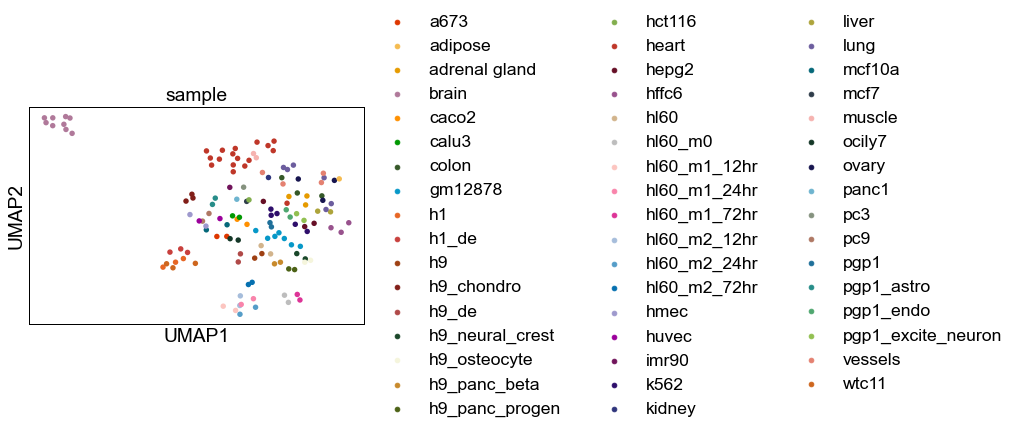

In [103]:
adata = sg.adata[:, tids]
len(adata.var.index)

# add colors
# map values in order specific to
cmap, order = get_biosample_colors()
adata.obs[obs_col] = adata.obs[obs_col].astype('category')
obs_order = list(adata.obs_names)
sample_order = adata.obs[obs_col].cat.categories.tolist()
print(sample_order)
print(adata.obs[obs_col].unique())
sample_colors = [cmap[s] for s in sample_order]
adata.uns['{}_colors'.format(obs_col)] = sample_colors

# normalize data matrix to 10,000 count
sc.pp.normalize_total(adata, target_sum=1e4)

# log 
sc.pp.log1p(adata)
adata.raw = adata

# find highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes = 70000, flavor = 'seurat',
    min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

# sc.tl.pca(adata, use_highly_variable=False)
sc.tl.pca(adata, use_highly_variable=True)

sc.pp.neighbors(adata, metric='cosine')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(adata, color='sample', frameon=True, size=120, show=False)

f = plt.gcf()
f.savefig('figures/lr_umap.pdf', dpi=500, bbox_inches='tight')
f.savefig('/Users/fairliereese/mortazavi_lab/documents/rnawg/fig1/lr_umap.pdf', dpi=500, bbox_inches='tight')



Trying to set attribute `.obs` of view, copying.


['cell_line', 'tissue', 'brain']
{'cell_line': '#7680e8', 'tissue': '#e39f24', 'brain': '#b0799a'}
['brain', 'cell_line', 'tissue']
['cell_line', 'brain', 'tissue']
Categories (3, object): ['brain', 'cell_line', 'tissue']


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'classification' as categorical


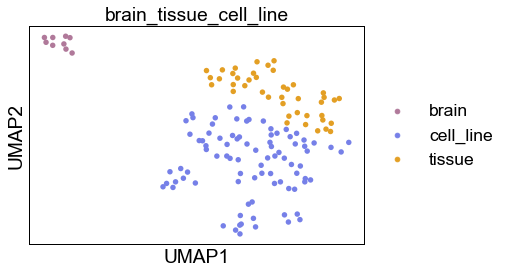

In [162]:
# colored by brain, tissue, or cell line
adata = sg.adata[:, tids]
len(adata.var.index)


obs_col = 'brain_tissue_cell_line'
adata.obs[obs_col] = adata.obs.classification
adata.obs.loc[adata.obs['sample']=='brain', obs_col] = 'brain'

# add colors
# map values in order specific to
cmap, order = get_tissue_cell_line_colors()
cmap2, _ = get_biosample_colors()
brain_color = cmap2['brain'] 
order += ['brain']
print(order)
cmap['brain'] = brain_color
print(cmap)
adata.obs[obs_col] = adata.obs[obs_col].astype('category')
obs_order = list(adata.obs_names)
sample_order = adata.obs[obs_col].cat.categories.tolist()
print(sample_order)
print(adata.obs[obs_col].unique())
sample_colors = [cmap[s] for s in sample_order]
adata.uns['{}_colors'.format(obs_col)] = sample_colors

# also store rgb values in dict for use with gen_report
for key, item in cmap.items():
    item = item[1:]
    r,g,b = tuple(int(item[i:i+2], 16) for i in (0, 2, 4))
    cmap[key] = (r,g,b)
adata.uns['{}_dict'.format(obs_col)] = cmap

# normalize data matrix to 10,000 count
sc.pp.normalize_total(adata, target_sum=1e4)

# log 
sc.pp.log1p(adata)
adata.raw = adata

# find highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes = 70000, flavor = 'seurat',
    min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

# sc.tl.pca(adata, use_highly_variable=False)
sc.tl.pca(adata, use_highly_variable=True)

sc.pp.neighbors(adata, metric='cosine')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(adata, color=obs_col, frameon=True, size=120, show=False)

f = plt.gcf()
f.savefig('figures/lr_umap_brain_tissue_cell_line.pdf', dpi=500, bbox_inches='tight')
f.savefig('/Users/fairliereese/mortazavi_lab/documents/rnawg/fig1/lr_umap_brain_tissue_cell_line.pdf', dpi=500, bbox_inches='tight')



Trying to set attribute `.obs` of view, copying.


['a673', 'adipose', 'adrenal gland', 'caco2', 'calu3', 'colon', 'gm12878', 'h1', 'h1_de', 'h9', 'h9_chondro', 'h9_de', 'h9_neural_crest', 'h9_osteocyte', 'h9_panc_beta', 'h9_panc_progen', 'hct116', 'heart', 'hepg2', 'hffc6', 'hl60', 'hl60_m0', 'hl60_m1_12hr', 'hl60_m1_24hr', 'hl60_m1_72hr', 'hl60_m2_12hr', 'hl60_m2_24hr', 'hl60_m2_72hr', 'hmec', 'huvec', 'imr90', 'k562', 'kidney', 'liver', 'lung', 'mcf10a', 'mcf7', 'muscle', 'ocily7', 'ovary', 'panc1', 'pc3', 'pc9', 'pgp1', 'pgp1_astro', 'pgp1_endo', 'pgp1_excite_neuron', 'vessels', 'wtc11']
['caco2', 'mcf10a', 'a673', 'lung', 'hl60_m0', ..., 'h9_osteocyte', 'h9_panc_beta', 'hepg2', 'hct116', 'kidney']
Length: 49
Categories (49, object): ['a673', 'adipose', 'adrenal gland', 'caco2', ..., 'pgp1_endo', 'pgp1_excite_neuron', 'vessels', 'wtc11']


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'classification' as categorical


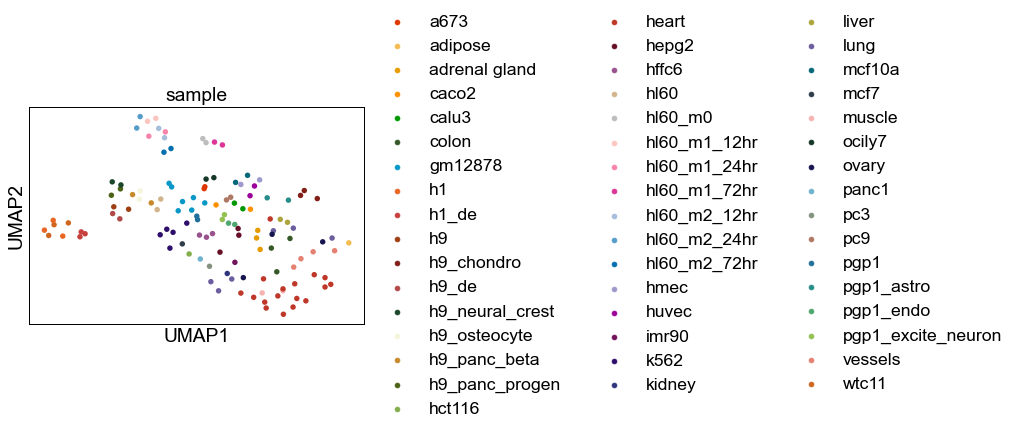

In [104]:
# w/o brain
adata = sg.adata[:, tids]
adata = adata[adata.obs['sample'] != 'brain']
len(adata.var.index)

# add colors
# map values in order specific to
cmap, order = get_biosample_colors()
adata.obs[obs_col] = adata.obs[obs_col].astype('category')
obs_order = list(adata.obs_names)
sample_order = adata.obs[obs_col].cat.categories.tolist()
print(sample_order)
print(adata.obs[obs_col].unique())
sample_colors = [cmap[s] for s in sample_order]
adata.uns['{}_colors'.format(obs_col)] = sample_colors

# normalize data matrix to 10,000 count
sc.pp.normalize_total(adata, target_sum=1e4)

# log 
sc.pp.log1p(adata)
adata.raw = adata

# find highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes = 70000, flavor = 'seurat',
    min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

# sc.tl.pca(adata, use_highly_variable=False)
sc.tl.pca(adata, use_highly_variable=True)

sc.pp.neighbors(adata, metric='cosine')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
sc.pl.umap(adata, color='sample', frameon=True, size=120, show=False)
f = plt.gcf()
f.savefig('figures/lr_umap_no_brain.pdf', dpi=500, bbox_inches='tight')
f.savefig('/Users/fairliereese/mortazavi_lab/documents/rnawg/fig1/lr_umap_no_brain.pdf', dpi=500, bbox_inches='tight')




In [ ]:
# just tissues
adata = sg.adata[:, tids]
adata = adata[adata.obs['classification'] == 'tissue']
len(adata.var.index)

# normalize data matrix to 10,000 count
sc.pp.normalize_total(adata, target_sum=1e4)

# log 
sc.pp.log1p(adata)
adata.raw = adata

# find highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes = 70000, flavor = 'seurat',
    min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

# sc.tl.pca(adata, use_highly_variable=False)
sc.tl.pca(adata, use_highly_variable=True)

sc.pp.neighbors(adata, metric='cosine')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
sc.pl.umap(adata, color='sample', frameon=True, size=120, show=False)
f = plt.gcf()
f.savefig('figures/lr_umap_tissue.pdf', dpi=500, bbox_inches='tight')
f.savefig('/Users/fairliereese/mortazavi_lab/documents/rnawg/fig1/lr_umap_tissue.pdf', dpi=500, bbox_inches='tight')


In [ ]:
# just cell lines
adata = sg.adata[:, tids]
adata = adata[adata.obs['classification'] == 'cell_line']
len(adata.var.index)

# normalize data matrix to 10,000 count
sc.pp.normalize_total(adata, target_sum=1e4)

# log 
sc.pp.log1p(adata)
adata.raw = adata

# find highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes = 70000, flavor = 'seurat',
    min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

# sc.tl.pca(adata, use_highly_variable=False)
sc.tl.pca(adata, use_highly_variable=True)

sc.pp.neighbors(adata, metric='cosine')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
sc.pl.umap(adata, color='sample', frameon=True, size=120, show=False)
f = plt.gcf()
f.savefig('figures/lr_umap_tissue.pdf', dpi=500, bbox_inches='tight')
f.savefig('/Users/fairliereese/mortazavi_lab/documents/rnawg/fig1/lr_umap_tissue.pdf', dpi=500, bbox_inches='tight')


In [124]:
# the old fashioned way

In [43]:
df = df.transpose()
df.reset_index(inplace=True)
df.rename({'index': 'dataset'}, axis=1, inplace=True)

In [44]:
df['biosample'] = df.dataset.str.rsplit('_', n=2, expand=True)[0]
df.drop(['dataset'], axis=1, inplace=True)

# record the highest TPM value per biosample
tissue_df = get_tissue_metadata()
tissue_df = tissue_df[['tissue', 'biosample']]

df = df.merge(tissue_df, how='left', on='biosample')
df.loc[df.tissue.isnull(), 'tissue'] = df.loc[df.tissue.isnull(), 'biosample']
df.drop('biosample', axis=1, inplace=True)
df.rename({'tissue': 'biosample'}, axis=1, inplace=True)

In [47]:
df.set_index('biosample', inplace=True)

In [48]:
c_dict, order = get_biosample_colors()

In [49]:
reducer = umap.UMAP()

In [50]:
df_data = df.values
df_scaled = StandardScaler().fit_transform(df_data)

In [51]:
len(df_scaled)

138

In [52]:
embedding = reducer.fit_transform(df_scaled)
embedding.shape

(138, 2)

In [55]:
umap_df = pd.DataFrame(data=embedding, columns=['x', 'y'])
umap_df['biosample'] = df.index.tolist()
umap_df.head()

,x,y,biosample
0,4.800972,12.905118,mcf7
1,4.756567,11.927515,k562
2,3.953222,14.553775,heart
3,4.781741,11.350097,gm12878
4,3.875915,14.758311,heart


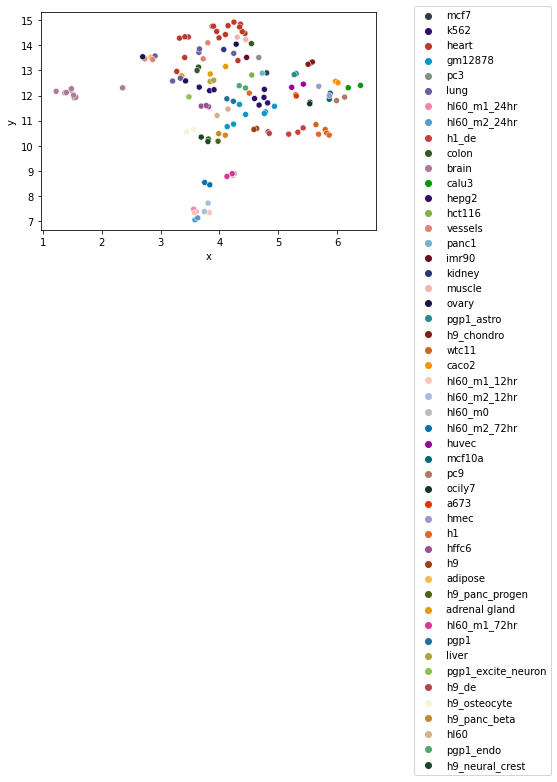

In [58]:
ax = sns.scatterplot(umap_df, x='x', y='y', hue='biosample', palette=c_dict)
ax.legend(bbox_to_anchor=(1.1, 1.05))

## Box plot for number of samples / libraries for human / mouse there are

In [2]:
human = pd.read_csv('swan/swan_metadata.tsv', sep='\t')
human['species'] = 'Human'

mouse = pd.read_csv('../mouse/lr_bulk/swan/mouse_metadata.tsv', sep='\t')
mouse['species'] = 'Mouse'

keep_cols = ['dataset', 'sample', 'classification', 'species']
human = human[keep_cols]
mouse = mouse[keep_cols]

df = pd.concat([human, mouse], axis=0)

In [3]:
df.to_csv('table.tsv', sep='\t')

In [4]:
# gb species and classification and count libraries
temp = df.groupby(['classification', 'species']).count().reset_index()
temp = temp[['classification', 'species', 'dataset']]
temp.rename({'dataset': 'n_libraries'}, axis=1, inplace=True)

In [5]:
# gb species and classification and count samples
temp2 = df.groupby(['classification', 'species']).nunique().reset_index()
temp2 = temp2[['classification', 'species', 'sample']]
temp2.rename({'sample': 'n_samples'}, axis=1, inplace=True)

In [6]:
temp = temp.merge(temp2, on=['species', 'classification'])

In [7]:
c_dict, order = get_tissue_cell_line_colors()

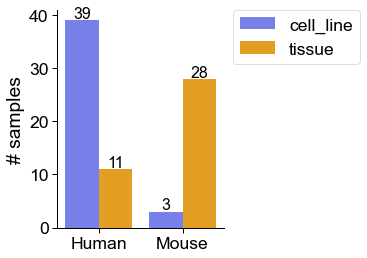

In [8]:
# n samples
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(3,4))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

ax = sns.barplot(data=temp2, x='species', y='n_samples',
            hue='classification',
            palette=c_dict, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

xlabel = ''
ylabel = '# samples'

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
_ = ax.set(xlabel=xlabel, ylabel=ylabel)
# ax.set_xticklabels(['vM25', 'Obs.', 'Obs. major'])

def add_perc_2(ax):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        label = '{:.0f}'.format(p.get_height())
        # n = p.get_height()
        # label = '{:.0f} samples'.format(temp.loc[temp.n_libraries == n, 'n_samples'].tolist()[0])
        x = p.get_x() + p.get_width() / 2
        # x = p.get_x() + p.get_width() / 2 - 0.3
        # x = p.get_x() + p.get_width() / 2 - (0.015)*n_cats
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(label, (x, y), size=16, horizontalalignment='center')


add_perc_2(ax)

fname = 'figures/data_summary_samples.pdf'
plt.savefig(fname, dpi=500, layout='tight', bbox_inches="tight")

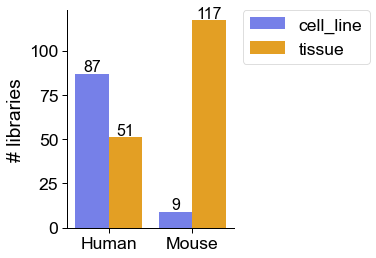

In [9]:
# n libraries
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(3,4))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

ax = sns.barplot(data=temp, x='species', y='n_libraries',
            hue='classification',
            palette=c_dict, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

xlabel = ''
ylabel = '# libraries'

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
_ = ax.set(xlabel=xlabel, ylabel=ylabel)
# ax.set_xticklabels(['vM25', 'Obs.', 'Obs. major'])

def add_perc_2(ax):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        label = '{:.0f}'.format(p.get_height())
        # n = p.get_height()
        # label = '{:.0f} samples'.format(temp.loc[temp.n_libraries == n, 'n_samples'].tolist()[0])
        x = p.get_x() + p.get_width() / 2
        # x = p.get_x() + p.get_width() / 2 - 0.3
        # x = p.get_x() + p.get_width() / 2 - (0.015)*n_cats
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(label, (x, y), size=16, horizontalalignment='center')


add_perc_2(ax)
fname = 'figures/data_summary_libraries.pdf'
plt.savefig(fname, dpi=500, layout='tight', bbox_inches="tight")

In [11]:
## Ali's categorizations - unique tissues / cell types

In [12]:
df = pd.read_csv('ali_sample_table.csv')

In [14]:
# gb species and classification and count tissue / cell type
temp2 = df.groupby(['classification', 'species']).nunique().reset_index()
temp2 = temp2[['classification', 'species', 'tissue / cell type']]
temp2.rename({'tissue / cell type': 'n_tissue_cell_type'}, axis=1, inplace=True)

In [16]:
temp2

,classification,species,n_tissue_cell_type
0,cell_line,Human,30
1,cell_line,Mouse,2
2,tissue,Human,11
3,tissue,Mouse,6


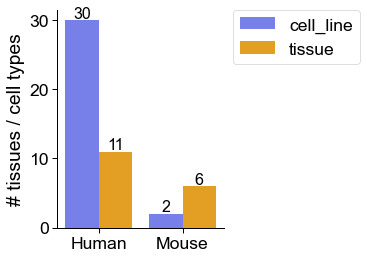

In [18]:
# n libraries
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(3,4))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

ax = sns.barplot(data=temp2, x='species', y='n_tissue_cell_type',
            hue='classification',
            palette=c_dict, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

xlabel = ''
ylabel = '# tissues / cell types'

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
_ = ax.set(xlabel=xlabel, ylabel=ylabel)
# ax.set_xticklabels(['vM25', 'Obs.', 'Obs. major'])

def add_perc_2(ax):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        label = '{:.0f}'.format(p.get_height())
        # n = p.get_height()
        # label = '{:.0f} samples'.format(temp.loc[temp.n_libraries == n, 'n_samples'].tolist()[0])
        x = p.get_x() + p.get_width() / 2
        # x = p.get_x() + p.get_width() / 2 - 0.3
        # x = p.get_x() + p.get_width() / 2 - (0.015)*n_cats
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(label, (x, y), size=16, horizontalalignment='center')


add_perc_2(ax)
fname = 'figures/data_summary_tissue_celltype.pdf'
plt.savefig(fname, dpi=500, layout='tight', bbox_inches="tight")

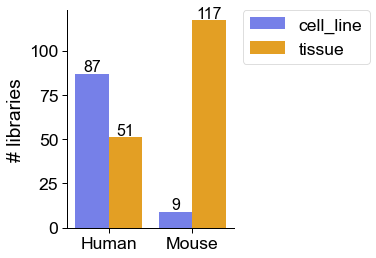

In [10]:
# n libraries
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(3,4))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

ax = sns.barplot(data=temp, x='species', y='n_libraries',
            hue='classification',
            palette=c_dict, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

xlabel = ''
ylabel = '# libraries'

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
_ = ax.set(xlabel=xlabel, ylabel=ylabel)
# ax.set_xticklabels(['vM25', 'Obs.', 'Obs. major'])

def add_perc_2(ax):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        label = '{:.0f}'.format(p.get_height())
        # n = p.get_height()
        # label = '{:.0f} samples'.format(temp.loc[temp.n_libraries == n, 'n_samples'].tolist()[0])
        x = p.get_x() + p.get_width() / 2
        # x = p.get_x() + p.get_width() / 2 - 0.3
        # x = p.get_x() + p.get_width() / 2 - (0.015)*n_cats
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(label, (x, y), size=16, horizontalalignment='center')


add_perc_2(ax)
fname = 'figures/data_summary_libraries.pdf'
plt.savefig(fname, dpi=500, layout='tight', bbox_inches="tight")